<a href="https://colab.research.google.com/github/finlytics-hub/marketing_analytics-RFM-Segmentation/blob/master/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Segmentation

## Introduction
Customer segmentation is at the heart of understanding your customer base and to design and implement effective, targeted and customised marketing startegies.

## Objective
Our objective here is to classify our segment base into clearly identifiable and distinct customer segments using the standard Recency, Frequency, Monetary (RFM) approach tied together with the statistical K-Means Clustering Model.

## Implementation
We will first determine each of our customers' RFM Values (individually for each of R, F & M) and RFM Scores (simple summation of the individual R, F & M values) and segment them based on the quantile distribution of RFM Scores. R, F & M values will be calculated from 1-4 based on quantiles, with 4 being the best Value.

We will then derive another set of segments through the K-Means Clustering Model when applied on the RFM Scores and compare and contrast the resulting two segments.

# Environment Setup

In [0]:
# Import all the required libraries
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import seaborn as sns

!pip install chart_studio 
import chart_studio.plotly as py
from plotly.subplots import make_subplots
import plotly.offline as pyoff
import plotly.graph_objs as go

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Load data. This dataset contains all purchases made for an online retail company based in the UK during an eight month period.
data = pd.read_csv("/content/drive/My Drive/Finlytics Hub/Data Science/Customer Analytics/OnlineRetail.csv", encoding = "unicode_escape")

# Exploratory Data Analysis & Feature Engineering

In [0]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Although there are some missing values in Description and CustomerID columns, we will not drop either, as none of them add any direct value to our segmentation analysis. Dropping them on the other hand will result in loss of data and important other features. Instead, let's assign a dummy value to empty CustomerID values

In [0]:
# Replace empty CustomerID with 11111
data["CustomerID"].fillna(11111, inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   541909 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [0]:
# Convert InvoiceDate to a DateTime format
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

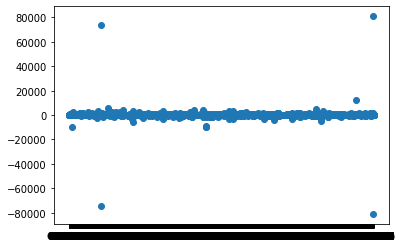

In [0]:
plt.scatter(data["InvoiceNo"], data["Quantity"])
plt.show()

The negative Quantity values could represent returns - might be a good idea to check with the business for validation of this assumption.

If it is so, then we don't really need to drop them as the M in RFM - when ordered at the CustomerID level - will take care of them.

Further, any positive Quantity outlier might result in a high M Score, but there's a chance that this specific Customer might be scored lower on R or F, thereby impacting the overall RFM Score that we would expect. It would be a similar scenario for any outlier in UnitPrice, so we would not check for any outlier there.

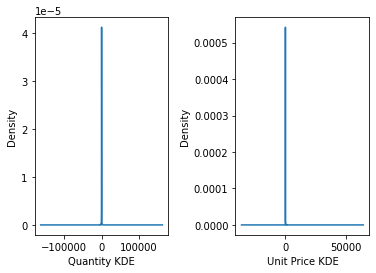

In [0]:
plt.subplot(1, 2, 1, xlabel = "Quantity KDE")
data["Quantity"].plot.kde()
plt.subplot(1, 2, 2, xlabel = "Unit Price KDE")
data["UnitPrice"].plot.kde()
plt.subplots_adjust(wspace = 0.5)
plt.show()

In [0]:
# Extract day, month and year from InvoiceDate column into a new column
data['InvoiceDay'] = data["InvoiceDate"].apply(lambda x: datetime(x.year, x.month, x.day))

In [0]:
# Add a new column for Total Invoice Amount
data['TotalSum'] = data["Quantity"] * data["UnitPrice"]
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,TotalSum
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34


# RFM Calculation

In [0]:
# Store the last invoice day + 1 in a new variable to Calculate Recency
pin_date = data["InvoiceDay"].max() + timedelta(1)

In [0]:
# calculate RFM values for each transaction and save them in a new DF
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate' : lambda x: (pin_date - x.max()).days,
    'InvoiceNo' : 'count', # Assuming each invoice is a separate purchase even if it was made wihtin a single day by the same customer 
    'TotalSum' : 'sum'})
# rename the columns
rfm.rename(columns = {'InvoiceDate' : 'Recency', 
                      'InvoiceNo' : 'Frequency', 
                      'TotalSum' : 'Monetary'}, inplace = True)
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
11111.0,0,135080,1447682.12
12346.0,325,2,0.00
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,18,73,1757.55


In [0]:
# Let's visualise the distribution of RFM
fig = make_subplots(rows=1, cols=3, subplot_titles=("Recency", "Frequency", "Monetary"))

fig.add_trace(
    go.Histogram(x=rfm["Recency"]),
    row=1, col=1
)

fig.add_trace(
    go.Histogram(x=rfm["Frequency"]),
    row=1, col=2
)

fig.add_trace(
    go.Histogram(x=rfm["Monetary"]),
    row=1, col=3
)
fig.update_layout(showlegend=False)
fig.show()

All are heavily right skewed.

We can see above that there are no negative values in Monetary as postulated at the beginning. The negative quantities have been set-off when aggregated at the CustomerID level

# Segmentation based on RFM Quartiles

In [0]:
# Create 4 RFM labels based on quartiles and assign them to groups from 1 to 4
r_labels = range(4, 0, -1) # the top 25% quartile will be assigned 4
r_groups = pd.qcut(rfm["Recency"], q = 4, labels = r_labels) # Assign the labels
f_labels = range(1, 5) # the top 25% quartile will be assigned 4
f_groups = pd.qcut(rfm["Frequency"], q = 4, labels = f_labels) # Assign the labels
m_labels = range(1, 5) # the top 25% quartile will be assigned 4
m_groups = pd.qcut(rfm["Monetary"], q = 4, labels = m_labels) # Assign the labels

In [0]:
# Now let’s make a new column for indicating group labels.
# make a new column for group labels
rfm["R"] = r_groups.values
rfm["F"] = f_groups.values
rfm["M"] = m_groups.values

# Concatenate & sum up the three columns
rfm["RFM_Segment"] = rfm.apply(lambda x: str(x['R']) + str(x['F']) + str(x['M']), axis = 1) 
rfm["RFM_Score"] = rfm[['R', 'F', 'M']].sum(axis = 1)
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
11111.0,0,135080,1447682.12,4,4,4,444,12.0
12346.0,325,2,0.00,1,1,1,111,3.0
12347.0,2,182,4310.00,4,4,4,444,12.0
12348.0,75,31,1797.24,2,2,4,224,8.0
12349.0,18,73,1757.55,3,3,4,334,10.0


In [0]:
# Assign RFM levels based on total score (Levels to be designed/identified by the business)
score_labels = ['Green', 'Bronze', 'Silver', 'Gold']
score_groups = pd.qcut(rfm["RFM_Score"], q = 4, labels = score_labels)
rfm['RFM_Level'] = score_groups.values
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level
CustomerID,,,,,,,,,
11111.0,0,135080,1447682.12,4,4,4,444,12.0,Gold
12346.0,325,2,0.00,1,1,1,111,3.0,Green
12347.0,2,182,4310.00,4,4,4,444,12.0,Gold
12348.0,75,31,1797.24,2,2,4,224,8.0,Silver
12349.0,18,73,1757.55,3,3,4,334,10.0,Silver


In [0]:
# Distribution of RFM Levels
plot_data = [
    go.Histogram(
        x=rfm['RFM_Level'],
        histnorm='percent'
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='RFM Level Distribution'
    )

fig = go.Figure(data=plot_data, layout=plot_layout)
fig.update_layout(xaxis={'categoryorder':'total descending'})
pyoff.iplot(fig)

~60% of our customers are classified as either Silver or Green

# Segmentation based on k Means Clustering of RFM Values

We knew from above that our RFM values are heavily skewed. In order for k Means Clustering to be effective, we need to do the following preprocessing:
* Perform log transformations to reduce skewness
* Normalise the date so that it has a mean of 0 and variance of 1

In [0]:
# Check for any negative values before performing log transformation
rfm[["Recency", "Frequency", "Monetary"]].describe()

,Recency,Frequency,Monetary
count,4373.000000,4373.000000,4.373000e+03
mean,91.560256,123.921564,2.229076e+03
std,100.770131,2054.469339,2.335683e+04
min,0.000000,1.000000,-4.287630e+03
25%,16.000000,17.000000,2.934500e+02
50%,50.000000,42.000000,6.484100e+02
75%,143.000000,102.000000,1.612130e+03
max,373.000000,135080.000000,1.447682e+06


In [0]:
# Replace the 0 and -ve Recency and Monetary values with 1
rfm["Recency"] = rfm["Recency"].apply(lambda x: 1 if x <= 0 else x)
rfm["Monetary"] = rfm["Monetary"].apply(lambda x: 1 if x <= 0 else x)
rfm[["Recency", "Frequency", "Monetary"]].describe()

,Recency,Frequency,Monetary
count,4373.000000,4373.000000,4.373000e+03
mean,91.569174,123.921564,2.232112e+03
std,100.762069,2054.469339,2.335641e+04
min,1.000000,1.000000,1.243450e-14
25%,16.000000,17.000000,2.934500e+02
50%,50.000000,42.000000,6.484100e+02
75%,143.000000,102.000000,1.612130e+03
max,373.000000,135080.000000,1.447682e+06


In [0]:
# We can see that Monetary has a very small positive minimum value - this will throw out the log transformation towards infinity
# So we will replae < 1 values for M with 1
rfm["Monetary"] = rfm["Monetary"].apply(lambda x: 1 if x < 1 else x)
rfm[["Recency", "Frequency", "Monetary"]].describe()

,Recency,Frequency,Monetary
count,4373.000000,4373.000000,4.373000e+03
mean,91.569174,123.921564,2.232113e+03
std,100.762069,2054.469339,2.335641e+04
min,1.000000,1.000000,1.000000e+00
25%,16.000000,17.000000,2.934500e+02
50%,50.000000,42.000000,6.484100e+02
75%,143.000000,102.000000,1.612130e+03
max,373.000000,135080.000000,1.447682e+06


In [0]:
# Let's unskew RFM values through log transformations
rfm_log = rfm[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis = 1).round(3)
rfm_log

,Recency,Frequency,Monetary
CustomerID,,,
11111.0,0.000,11.814,14.185
12346.0,5.784,0.693,0.000
12347.0,0.693,5.204,8.369
12348.0,4.317,3.434,7.494
12349.0,2.890,4.290,7.472
...,...,...,...
18280.0,5.624,2.303,5.196
18281.0,5.193,1.946,4.392
18282.0,1.946,2.565,5.174


In [0]:
# scale the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

# transform into a dataframe
rfm_scaled = pd.DataFrame(rfm_scaled, index = rfm.index, columns = rfm_log.columns)
rfm_scaled

,Recency,Frequency,Monetary
CustomerID,,,
11111.0,-2.450951,6.036423,5.329993
12346.0,1.381182,-2.222699,-4.494019
12347.0,-1.991811,1.127440,1.302044
12348.0,0.409236,-0.187068,0.696051
12349.0,-0.536209,0.448649,0.680815
...,...,...,...
18280.0,1.275176,-1.027016,-0.895459
18281.0,0.989621,-1.292146,-1.452280
18282.0,-1.161648,-0.832439,-0.910696


In [0]:
# Let's visualise the distributions of RFM again to ensure correct preprocessing
fig = make_subplots(rows=1, cols=3, subplot_titles=("Recency", "Frequency", "Monetary"))

fig.add_trace(
    go.Histogram(x=rfm_scaled["Recency"]),
    row=1, col=1
)

fig.add_trace(
    go.Histogram(x=rfm_scaled["Frequency"]),
    row=1, col=2
)

fig.add_trace(
    go.Histogram(x=rfm_scaled["Monetary"]),
    row=1, col=3
)
fig.update_layout(showlegend=False)
fig.show()

In [0]:
# Check mean and STD
rfm_scaled.describe()

,Recency,Frequency,Monetary
count,4.373000e+03,4.373000e+03,4.373000e+03
mean,4.557408e-17,-4.794549e-17,-3.781308e-16
std,1.000114e+00,1.000114e+00,1.000114e+00
min,-2.450951e+00,-2.737362e+00,-4.494019e+00
25%,-6.137266e-01,-6.334064e-01,-5.588735e-01
50%,1.409069e-01,3.870085e-02,-9.670707e-03
75%,8.372368e-01,6.974402e-01,6.205620e-01
max,1.472613e+00,6.036423e+00,5.329993e+00


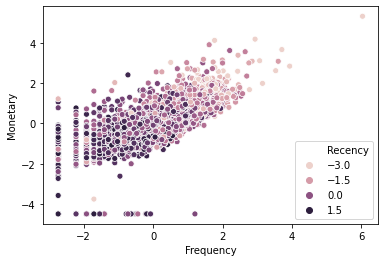

In [0]:
# Let's visualize if there are any obvious segments based on our log tansformed and scaled R, F, M values
sns.scatterplot(x = rfm_scaled["Frequency"], y = rfm_scaled["Monetary"], hue = rfm_scaled["Recency"])
plt.show()

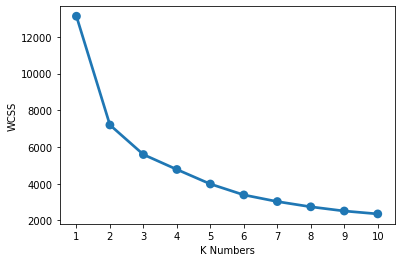

In [0]:
# Determine the optimum number of clusters (k) using the Elbow method
wcss = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters= k)
    kmeans.fit(rfm_scaled)
    wcss[k] = kmeans.inertia_
# plot the WCSS values
sns.pointplot(x = list(wcss.keys()), y = list(wcss.values()))
plt.xlabel('K Numbers')
plt.ylabel('WCSS')
plt.show()

In [0]:
# Looks like the ideal number of clusters is 3
# We can now build a model based on 3 clusters. Let’s make a new column and assign the labels to each customer in our rfm DF

# clustering
clus = KMeans(n_clusters= 3)
clus.fit(rfm_scaled)

# Assign the clusters to rfm DF
rfm['K_Cluster'] = clus.labels_
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level,K_Cluster
CustomerID,,,,,,,,,,
11111.0,1,135080,1447682.12,4,4,4,444,12.0,Gold,1
12346.0,325,2,1.00,1,1,1,111,3.0,Green,2
12347.0,2,182,4310.00,4,4,4,444,12.0,Gold,1
12348.0,75,31,1797.24,2,2,4,224,8.0,Silver,0
12349.0,18,73,1757.55,3,3,4,334,10.0,Silver,1


Now our rfm DF has 2 types of segments: RFM quantile groups and K-Means groups. Let’s make visualization and compare the two methods.

# Visualisations and Segment Comparisons

In [0]:
# Create columns to assign the two clustering labels. 
rfm_scaled['K_Cluster'] = clus.labels_
rfm_scaled['RFM_Level'] = rfm.RFM_Level
rfm_scaled.reset_index(inplace = True)
rfm_scaled.head()

,CustomerID,Recency,Frequency,Monetary,K_Cluster,RFM_Level
0,11111.0,-2.450951,6.036423,5.329993,1,Gold
1,12346.0,1.381182,-2.222699,-4.494019,2,Green
2,12347.0,-1.991811,1.127440,1.302044,1,Gold
3,12348.0,0.409236,-0.187068,0.696051,0,Silver
4,12349.0,-0.536209,0.448649,0.680815,1,Silver


In [0]:
# Reshape the data frame by melting (converting to the long form) the RFM values into one column.
# Each customer's R, F & M scores will be in a separate row
rfm_melted = pd.melt(frame = rfm_scaled, id_vars = ['CustomerID', 'RFM_Level', 'K_Cluster'], var_name = 'Metrics', value_name = 'Value')
print(rfm_melted.head())
rfm_melted[rfm_melted["CustomerID"] == 12346.0]

   CustomerID RFM_Level  K_Cluster  Metrics     Value
0     11111.0      Gold          1  Recency -2.450951
1     12346.0     Green          2  Recency  1.381182
2     12347.0      Gold          1  Recency -1.991811
3     12348.0    Silver          0  Recency  0.409236
4     12349.0    Silver          1  Recency -0.536209


,CustomerID,RFM_Level,K_Cluster,Metrics,Value
1,12346.0,Green,2,Recency,1.381182
4374,12346.0,Green,2,Frequency,-2.222699
8747,12346.0,Green,2,Monetary,-4.494019


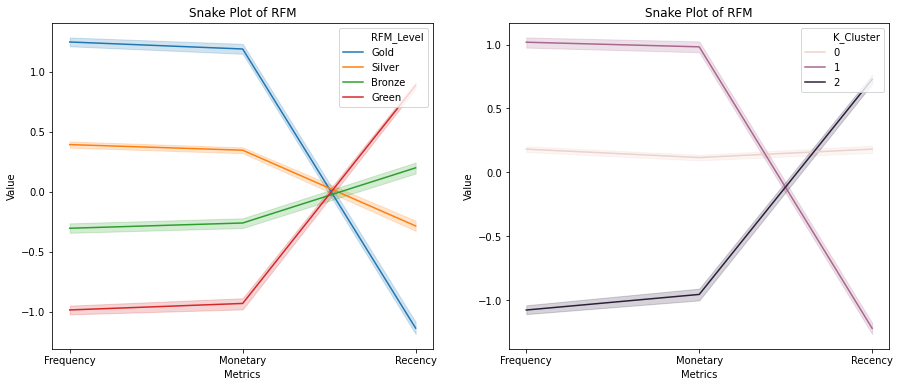

In [0]:
# Snake plot with RFM
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
# By default, the lineplot aggregates over multiple y values at each value of x and shows an estimate of the central tendency (e.g. mean)
# and a confidence interval for that estimate.
sns.lineplot(x = 'Metrics', y = 'Value', hue = 'RFM_Level', hue_order =["Gold", "Silver", "Bronze", "Green"], data = rfm_melted)
plt.title('Snake Plot of RFM')
plt.legend(loc = 'upper right')

# S snake plot with K-Means
plt.subplot(1, 2, 2)
sns.lineplot(x = 'Metrics', y = 'Value', hue = 'K_Cluster', data = rfm_melted)
plt.title('Snake Plot of RFM')
plt.legend(loc = 'upper right')

plt.show()

It seems Gold and Green groups on the left plot are similar with 1 and 2 clusters on the right plot. And the Bronze and Silver groups seem to be merged into group 0.

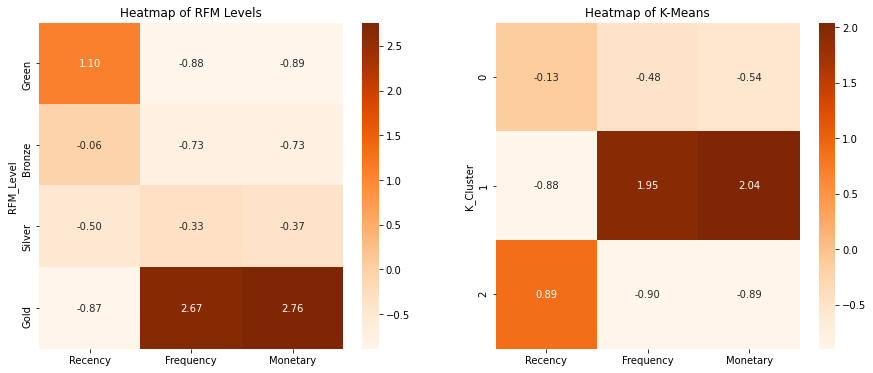

In [0]:
# Let's represent our segments in a Heatmap now
# Calculate mean values for each of R, F & M columns across the population
total_avg = rfm.iloc[:, 0:3].mean()
total_avg

# calculate the mean for each of R, F & M for each RFM level
cluster_avg = rfm.groupby('RFM_Level').mean().iloc[:, 0:3]
# calculate the percentage gap of each RFM level with total mean
prop_rfm = cluster_avg/total_avg - 1

# calculate the mean for each of R, F & M for each K_Cluster
cluster_avg_K = rfm.groupby('K_Cluster').mean().iloc[:, 0:3]
# calculate the percentage gap of each K_Cluster with total mean
prop_rfm_K = cluster_avg_K/total_avg - 1

plt.figure(figsize=(15,6))

# Represent the above % differences in a heatmap with RFM Levels
plt.subplot(1, 2, 1)
sns.heatmap(prop_rfm, cmap= 'Oranges', fmt= '.2f', annot = True)
plt.title('Heatmap of RFM Levels')

# Represent the above % differences in a heatmap with K_Clusters
plt.subplot(1, 2, 2)
sns.heatmap(prop_rfm_K, cmap= 'Oranges', fmt= '.2f', annot = True)
plt.title('Heatmap of K-Means')

plt.show()

RFM_Levels:
* Gold customers have F and M values higher than average values with lower R average
* Green customers are relatively new customers with understandably lower F and M

K_Clusters
* Cluster 0 appears to be similar to our Green customers: more recent purchases but with low frequency and of less monetary value
* Cluster 2 appears to be similar to our Gold customers: High frequency and high value purchases but in relatively distant past
* Cluster 1 appears to be a mix of Silver and Bronze customers

All the above ties up with our Snake Plots

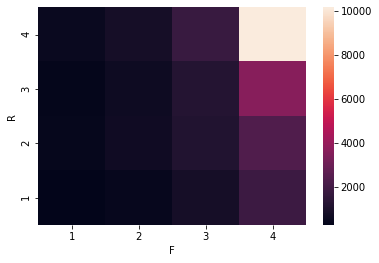

In [0]:
# Let's visualise a heatmap of the average Monetary spend across various R & F values
rfm_pivot = rfm.copy()
rfm_pivot.reset_index(inplace = True)
rfm_pivot = rfm_pivot.pivot_table(index = "R", columns = "F", values = "Monetary")
sns.heatmap(rfm_pivot)
plt.show()

We can see from the above that the highest average Monetary spend is by customers in the highest R & F categories. Also, customers with a higher Frequency and a lower Recency also spend on average more than those with lower Frequency.

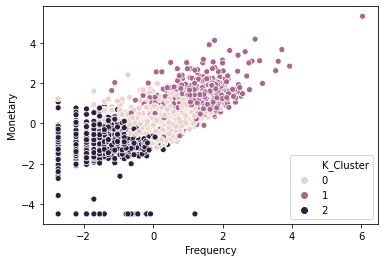

In [0]:
# Let's visualize our K Clusters across Frequency and Monetary
sns.scatterplot(x = rfm_scaled["Frequency"], y = rfm_scaled["Monetary"], hue = rfm_scaled["K_Cluster"])
plt.show()

We can see above that our 3 K Clusters are more or less clearly distinctive

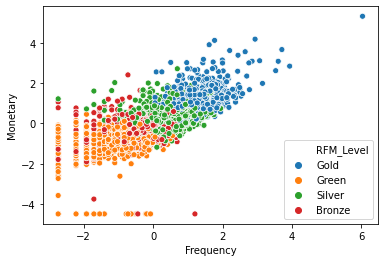

In [0]:
# Let's visualize our RFM_Levels across Frequency and Monetary
sns.scatterplot(x = rfm_scaled["Frequency"], y = rfm_scaled["Monetary"], hue = rfm_scaled["RFM_Level"])
plt.show()

Other than the Gold cluster (which is clearly differentiated from the rest), the remaining three RFM_Levels are kind of mixed up - so it might be a better idea to proceed our marketing campaings based on the 3 K_Clusters.

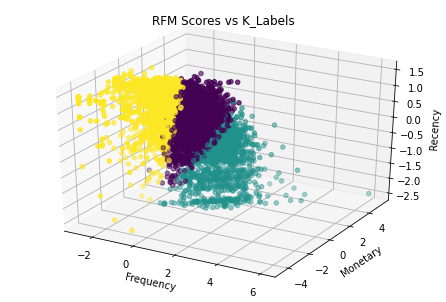

In [0]:
# Now let's create a 3D scatter plot of each of our R, F & M values together with the 3 K_Clusters
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(rfm_scaled["Frequency"], rfm_scaled["Monetary"], rfm_scaled["Recency"], c = rfm_scaled["K_Cluster"])
ax.set_xlabel("Frequency")
ax.set_ylabel("Monetary")
ax.set_zlabel("Recency")
ax.set_title("RFM Scores vs K_Labels")
plt.show()

Wow - a clear distinction indeed!

# Cross checking

In [0]:
# Confirm our above hypothesis - whether majority of Gold customers are also classified in 2
rfm[rfm["RFM_Level"] == "Gold"].head(10)

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level,K_Cluster
CustomerID,,,,,,,,,,
11111.0,1,135080,1447682.12,4,4,4,444,12.0,Gold,1
12347.0,2,182,4310.00,4,4,4,444,12.0,Gold,1
12357.0,33,131,6207.67,3,4,4,344,11.0,Gold,1
12359.0,7,254,6245.53,4,4,4,444,12.0,Gold,1
12362.0,3,274,5154.58,4,4,4,444,12.0,Gold,1
12380.0,21,105,2720.56,3,4,4,344,11.0,Gold,1
12381.0,4,91,1803.96,4,3,4,434,11.0,Gold,1
12388.0,15,100,2780.66,4,3,4,434,11.0,Gold,1
12395.0,15,159,2998.28,4,4,4,444,12.0,Gold,1


In [0]:
# Confirm our above hypothesis - whether majority of Green customers are also classified in 0
rfm[rfm["RFM_Level"] == "Green"].head(10)

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level,K_Cluster
CustomerID,,,,,,,,,,
12346.0,325,2,1.00,1,1,1,111,3.0,Green,2
12350.0,310,17,334.40,1,1,2,112,4.0,Green,2
12353.0,204,4,89.00,1,1,1,111,3.0,Green,2
12355.0,214,13,459.40,1,1,2,112,4.0,Green,2
12361.0,287,10,189.90,1,1,1,111,3.0,Green,2
12365.0,291,23,320.69,1,2,2,122,5.0,Green,2
12373.0,311,14,364.60,1,1,2,112,4.0,Green,2
12386.0,337,10,401.90,1,1,2,112,4.0,Green,2
12401.0,303,5,84.30,1,1,1,111,3.0,Green,2


In [0]:
# Confirm our above hypothesis - whether majority of Silver/Bronze customers are also classified in 1
print(rfm[rfm["RFM_Level"] == "Silver"].head(10))
print(rfm[rfm["RFM_Level"] == "Bronze"].head(10))

            Recency  Frequency  Monetary  ... RFM_Score RFM_Level K_Cluster
CustomerID                                ...                              
12348.0          75         31   1797.24  ...       8.0    Silver         0
12349.0          18         73   1757.55  ...      10.0    Silver         1
12352.0          36         95   1545.41  ...       9.0    Silver         0
12356.0          22         59   2811.43  ...      10.0    Silver         0
12358.0           1         19   1168.06  ...       9.0    Silver         1
12360.0          52        129   2662.06  ...      10.0    Silver         0
12364.0           7         85   1313.10  ...      10.0    Silver         1
12370.0          51        167   3545.69  ...      10.0    Silver         0
12371.0          44         63   1887.96  ...      10.0    Silver         0
12372.0          71         52   1298.04  ...       8.0    Silver         0

[10 rows x 10 columns]
            Recency  Frequency  Monetary  ... RFM_Score RFM_Leve

# Conclusion

Various marketing strategies could be directed to different segments as identified above.
* Green or 0 K_Cluster with most recent purchases can be targeted with special offers to encourage more purchases (thereby increasing F and M)
* Silver/Bronze or or 1 K_Cluster with below average across RFM values can be targeted differently to either increase frequency or recency